# Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析
- torch.nn.functional模块
- nn.Module模块

## 读取 mnist数据集

- 会自动下载数据

In [99]:
import gzip
from pathlib import Path
import pickle

from matplotlib import pyplot
import requests
import torch

DATA_PATH = Path('../../data')
FILE_PATH = DATA_PATH / 'mnist' # 类型是 WindowsPath('../data/mnist')
FILE_PATH.mkdir(parents=True,exist_ok=True)
# URL = 'http://deeplearning.net/data/mnist/'
URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/'
FILE_NAME = 'mnist.pkl.gz'

# 如果不存在就下载
if not (FILE_PATH / FILE_NAME).exists():
    content = requests.get(URL+FILE_NAME).content
    (FILE_PATH/FILE_NAME).open("wb").write(content)

In [100]:
# with 就是自动关闭流的操作. 跟try(){一个概念, 然后后面根的就是流的名称
# as_posix()作用于文件路径上 意思就是将文件路径转换为一个"/"路径,用于windows, 比如 'c:/application/a/b/c'
# pickle工具是序列化工具可以将文件读取成为数据, 也可以写入硬盘 pickle.load就是将文件序列化读出来
with gzip.open((FILE_PATH/FILE_NAME).as_posix(),'rb') as f:
    ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')

每一个文件都是28*28=784个像素点的文件. 每一个样本都是一样的

(50000, 784)


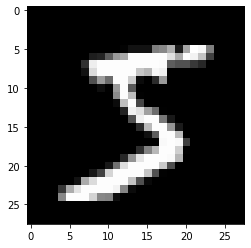

In [101]:
pyplot.imshow(x_train[0].reshape((28,28)),cmap="gray")
print(x_train.shape) # 这里我们用了灰度颜色通道. 并没有使用彩色颜色通道, 因此就是28*28*1

我们使用onehotencoding编码, 最终得到10个概率. 也就是最后的输出一层为10各节点来返回每一个数字的可能性概率. 因此在训练的时候需要将ylabels进行onehot处理

![image](./assets/4.png)

![image](./assets/5.png)


In [102]:
# map方法, 第一个参数是处理方法
# 第二个参数是目标数据, 输出的结果也是解构的结果.
x_train,y_train,x_valid,y_valid=map(torch.tensor,(x_train,y_train,x_valid,y_valid))

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到
torch.nn.functional中有很多功能，后续会常用的。

那什么时候使用nn.Module，什么时候使用nn.functional呢？

一般情况下，如果模型有可学习的参数，也就是有$w_1,w_2...$和$b$的时候, 最好用nn.Module，其他情况nn.functional相对更简单一些

In [103]:
import torch.nn.functional as F

# 损失函数, 这里用的是函数本身而不是返回值. 一般是不带参数的损失函数
loss_function = F.cross_entropy

In [104]:
bs=64
xb=x_train[0:bs] # 切片操作, 将x_train看做一个array. 然后获取array的0到64个元素
yb=y_train[0:bs]

# 随机一些权重
weights = torch.randn([784,10],dtype=torch.float,requires_grad=True)
bias = torch.zeros(10,requires_grad=True)

In [105]:
def model(data):
    return data.mm(weights) + bias

print(loss_function(model(xb),yb)) # 直接传入预测值和标签值就可以了

tensor(12.1908, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码
- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [106]:
from torch import nn
# 集成nn.Module
class Minist_NN(nn.Module):
    def __init__(self):
        # 必须集成构造函数, 要求的
        super().__init__()
        self.hidden1=nn.Linear(784,128) # 创建隐层
        self.hidden2=nn.Linear(128,256)
        self.out=nn.Linear(256,10)
        
    def forward(self,x): 
        # 定义前向传播. 对隐层进行
        x=F.relu(self.hidden1(x))
        x=F.relu(self.hidden2(x))
        x=self.out(x)
        return x

In [107]:
net = Minist_NN()
print(net)

Minist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [108]:
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())
    
# 默认情况下权重会被初始化

hidden1.weight Parameter containing:
tensor([[-0.0265, -0.0195, -0.0033,  ..., -0.0017,  0.0251,  0.0306],
        [ 0.0018, -0.0230,  0.0339,  ...,  0.0002, -0.0302,  0.0286],
        [-0.0346,  0.0007, -0.0188,  ...,  0.0220,  0.0017,  0.0130],
        ...,
        [-0.0300, -0.0095,  0.0346,  ..., -0.0214,  0.0023,  0.0181],
        [ 0.0345, -0.0091, -0.0332,  ...,  0.0052, -0.0267, -0.0099],
        [-0.0139, -0.0030,  0.0022,  ...,  0.0300, -0.0019, -0.0125]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([-0.0132, -0.0202,  0.0097, -0.0182,  0.0323, -0.0012,  0.0209,  0.0125,
         0.0327,  0.0130, -0.0239,  0.0205, -0.0121, -0.0102, -0.0063, -0.0323,
         0.0002, -0.0238,  0.0165, -0.0343, -0.0276,  0.0059, -0.0319, -0.0343,
         0.0073, -0.0345,  0.0179, -0.0082, -0.0061, -0.0264,  0.0047, -0.0323,
        -0.0248, -0.0242, -0.0228,  0.0155, -0.0096, -0.0323, -0.0012,  0.0274,
         0.0065,  0.0095, -0.0265, -0.0199, 

### 使用TensorDataset和DataLoader来简化

In [109]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# 数据集构建辅助工具, 将数据集转化为dataset类型.
train_ds = TensorDataset(x_train,y_train)
# 将dataset类型的数据根据批次产出. 减少计算压力, 想象一下矩阵运算, 庞大的矩阵运算很慢, 用比较小的矩阵运算可以更好的利用内存.
train_dl = DataLoader(train_ds,batch_size=bs,shuffle=True)

valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(valid_ds,batch_size=bs * 2,shuffle=True)

In [110]:
# 定义一个数据提取器, 每次提取批次的数据
def get_data(train_ds,valid_ds,bs):
    return (DataLoader(train_ds,batch_size=bs,shuffle=True),DataLoader(valid_ds,batch_size=bs*2))

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [111]:
import numpy as np
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb) # 计算损失, 得到预测结果和应当的结果
    if opt is not None:
        loss.backward() # 反向传播, 这里反向传播了模型的参数
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [112]:
# steps 迭代的次数
# model 训练的模型
# loss_func 损失函数
# opt 优化器optimizer
# dl 数据迭代器
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train() # 训练一次, 下面的for循环才是计算损失函数然后迭代, 这里只是提前训练一次模型
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt) # 调用loss_batch来就算损失函数

        # 计算一次损失.
        model.eval() 
        # torch.no_grad() 是一个上下文管理器，用来禁止梯度的计算，通常用来网络推断中，它可以减少计算内存的使用量
        # 在这里就是阻止了反向传播的计算. 主要是这里是要求打印损失值,而不需要真正的反向传播计算
        with torch.no_grad(): 
            # 对每一个x,y进行损失值计算然后封装到losses中. 由于在no_grad中所以没有反向传播
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # 计算当前batch的损失值, 然后输出
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [113]:
from torch import optim
def get_model():
    # 得到模型同时获得优化器, 使用模型中的默认参数
    returnModal = Minist_NN()
    return returnModal, optim.SGD(returnModal.parameters(), lr=0.001)

In [114]:
# 执行的时候直接调用这个工具类就可以进行训练了
train_dl, train_ds = get_data(train_ds,valid_ds,bs)
model,opt=get_model()
fit(25,model,loss_function,opt,train_dl,valid_dl)


当前step:0 验证集损失：2.278320760345459
当前step:1 验证集损失：2.2438408145904543
当前step:2 验证集损失：2.1903117893218993
当前step:3 验证集损失：2.102310284423828
当前step:4 验证集损失：1.959914992904663
当前step:5 验证集损失：1.748250100517273
当前step:6 验证集损失：1.4883616399765014
当前step:7 验证集损失：1.2371993240356445
当前step:8 验证集损失：1.0349678510665894
当前step:9 验证集损失：0.8828164986610413
当前step:10 验证集损失：0.7705935660362244
当前step:11 验证集损失：0.6864762427330017
当前step:12 验证集损失：0.6230419251441955
当前step:13 验证集损失：0.5739328969478608
当前step:14 验证集损失：0.5355695337295532
当前step:15 验证集损失：0.5047394303321838
当前step:16 验证集损失：0.47971986780166626
当前step:17 验证集损失：0.4583516550540924
当前step:18 验证集损失：0.4408131406545639
当前step:19 验证集损失：0.4259066216468811
当前step:20 验证集损失：0.41275083196163176
当前step:21 验证集损失：0.401344664812088
当前step:22 验证集损失：0.39153350558280947
当前step:23 验证集损失：0.3828226818084717
当前step:24 验证集损失：0.37505417428016663
